# Seoul Bike Rental Prediction

The following dataset contanins information on a bike rental service in Seoul, South Korea from December 2017 and November 2018. The bike rental company will need to know how many bikes are needed for the day or even specific hour in order to assure that the supply can meet demand. Accurate prediction of the bikes needed will be crucial for the business to thrive. 

The goal of this project is to use regression methods to predict the number of bike rentals given information about the time/date and weather. These variables are described as follows: <br>
- Date
- Rented bike count
- Hour - hour of the day
- Temperature (Celcius)
- Humidity (%)
- Wind speed (m/s)
- visibility (10m)
- Dew point temperature (Celcius)
- Solar radiation (mJ/m2)
- Rainfall (mm)
- snowfall (cm)
- Seasons - current season of the year
- Holiday 
- Functioning Day - bike rental functioning


## Load the dataset and view first 5 rows of data

In [1]:
# import necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# change directory
os.chdir('/Users/david/Desktop/python_datasets')
# import dataset
bike_share = pd.read_csv("SeoulBikeData.csv", encoding='ISO-8859-1')
pd.options.display.max_columns = 15
# view dataset
print(bike_share.info())
print(bike_share.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

The dataset loaded and imported properly.

## look at some statistics on the data

In [2]:
# view descriptive statistics
print(bike_share.describe(), '\n')

cat_vars = ['Seasons', 'Holiday', 'Functioning Day']
for x in cat_vars:
    print(x, ' value counts:', '\n',
          bike_share[x].value_counts(), '\n')

       Rented Bike Count         Hour  Temperature(°C)  Humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.250000    17.250000        22.500000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
count       8760.000000       8760.000000                8760.000000   
mean           1.724909       1436.825799                   4.073813   
std            1.036300        608.298712                  13.060369   
min            0.000000         27.000000                 -30.600000   


These summary statistics appear uneventful. Next, a heatmap of the correlation coefficient will be produced. 

Text(0.5, 1.0, 'Heatmap of correlation coefficient')

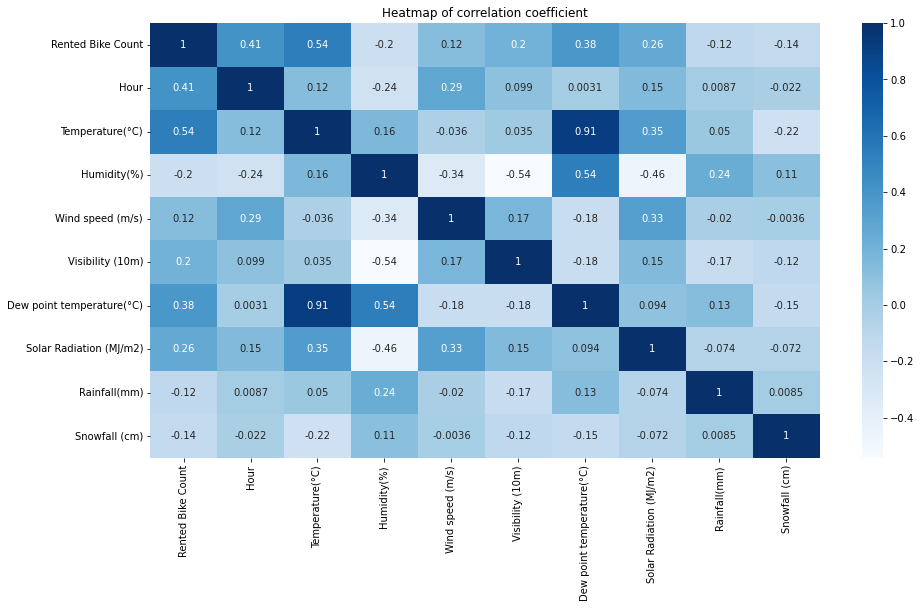

In [3]:
# plot correlation heatmap
plt.figure(figsize=(15, 8))
bike_corr = bike_share.corr()
sns.heatmap(bike_corr, cmap="Blues", annot=True).set_title("Heatmap of correlation coefficient")

- Temperature and hour have the highest correlation to the number of bike rentals.
- Temperature and humidity also have high correlation to dew point temperature, however this is to be expected because dew point temperature is calculated from these two variables.
- Humidity has a negative correlation to solar radiation, visibility and wind speed. 

In [4]:
#rename columns to make easier to work with
bike_share.rename(columns={'Rented Bike Count': 'bike_count',
                           'Hour': 'hour',
                           'Temperature(°C)': 'temp_c',
                           'Humidity(%)': 'humidity',
                           'Wind speed (m/s)': 'wind_speed',
                           'Visibility (10m)': 'visibility',
                           'Dew point temperature(°C)': 'dew_point',
                           'Solar Radiation (MJ/m2)': 'solar_rad',
                           'Rainfall(mm)': 'rain_mm',
                           'Snowfall (cm)': 'snow_mm',
                           'Seasons': 'season',
                           'Holiday': 'holiday',
                           'Functioning Day': 'functioning'},
                  inplace=True)

# print variances
cont_var = ['bike_count', 'temp_c', 'humidity', 'wind_speed', 'visibility', 'dew_point', 'solar_rad', 'rain_mm', 'snow_mm']
all_variance = bike_share[cont_var].var()
print('Variance of continuous variables: ', '\n',
     all_variance)

Variance of continuous variables:  
 bike_count    416021.733390
temp_c           142.678850
humidity         414.627875
wind_speed         1.073918
visibility    370027.323001
dew_point        170.573247
solar_rad          0.754720
rain_mm            1.272819
snow_mm            0.190747
dtype: float64


bike_count and visibility have a high variance, if the model gives poor prediction these variables will be log transformed to help lower the variance. 

# Begin data manipulation
- The 'Hour' variable will be added to the 'Date' which will then be converted to a datetime index
- The variable names will be changed to be easier to work with, such as removing parenthesis, capitalization and spaces
- The 'Holiday' variable responses are 'No Holiday' or 'Holiday', this will be changed to 'No'/'Yes' in order to be in the same   format as the 'Functioning Day' variable

In [5]:
# add minutes and seconds to hour in order to change it to a proper datetime format
hours = bike_share['hour'].tolist()
time = []

for hour in hours:
    if (hour < 10):
        time.append("0" + str(hour) + ":00:00")
    else :
        time.append(str(hour) + ":00:00")

bike_share['time'] = pd.DataFrame(time)

# convert 'Date' to a string and append 'time'
bike_share['date_time'] = bike_share['Date'] + " " + bike_share['time']

bike_share['date_time'] = pd.to_datetime(bike_share['date_time'], format="%d/%m/%Y %H:%M:%S")

bike_share.drop(columns=['Date', 'time'], axis=1, inplace=True)

# set index to the date_time column
bike_share = bike_share.set_index(pd.DatetimeIndex(bike_share['date_time']))

# change the 'holiday' response from Holiday/No Holiday to Yes/No
bike_share['holiday'].replace('No Holiday', 'No', inplace=True)
bike_share['holiday'].replace('Holiday', 'Yes', inplace=True)
print(bike_share.head())

                     bike_count  hour  temp_c  humidity  wind_speed  \
date_time                                                             
2017-12-01 00:00:00         254     0    -5.2        37         2.2   
2017-12-01 01:00:00         204     1    -5.5        38         0.8   
2017-12-01 02:00:00         173     2    -6.0        39         1.0   
2017-12-01 03:00:00         107     3    -6.2        40         0.9   
2017-12-01 04:00:00          78     4    -6.0        36         2.3   

                     visibility  dew_point  solar_rad  rain_mm  snow_mm  \
date_time                                                                 
2017-12-01 00:00:00        2000      -17.6        0.0      0.0      0.0   
2017-12-01 01:00:00        2000      -17.6        0.0      0.0      0.0   
2017-12-01 02:00:00        2000      -17.7        0.0      0.0      0.0   
2017-12-01 03:00:00        2000      -17.6        0.0      0.0      0.0   
2017-12-01 04:00:00        2000      -18.6        0.

# Plot the data

## Twin axes plot

The next sequence of plots use a twin x-axis, with a variable plotted against the number of bike rentals. These plots use the rolling average of the past 24 hours in order to reduce the 'noise' in the plot. 

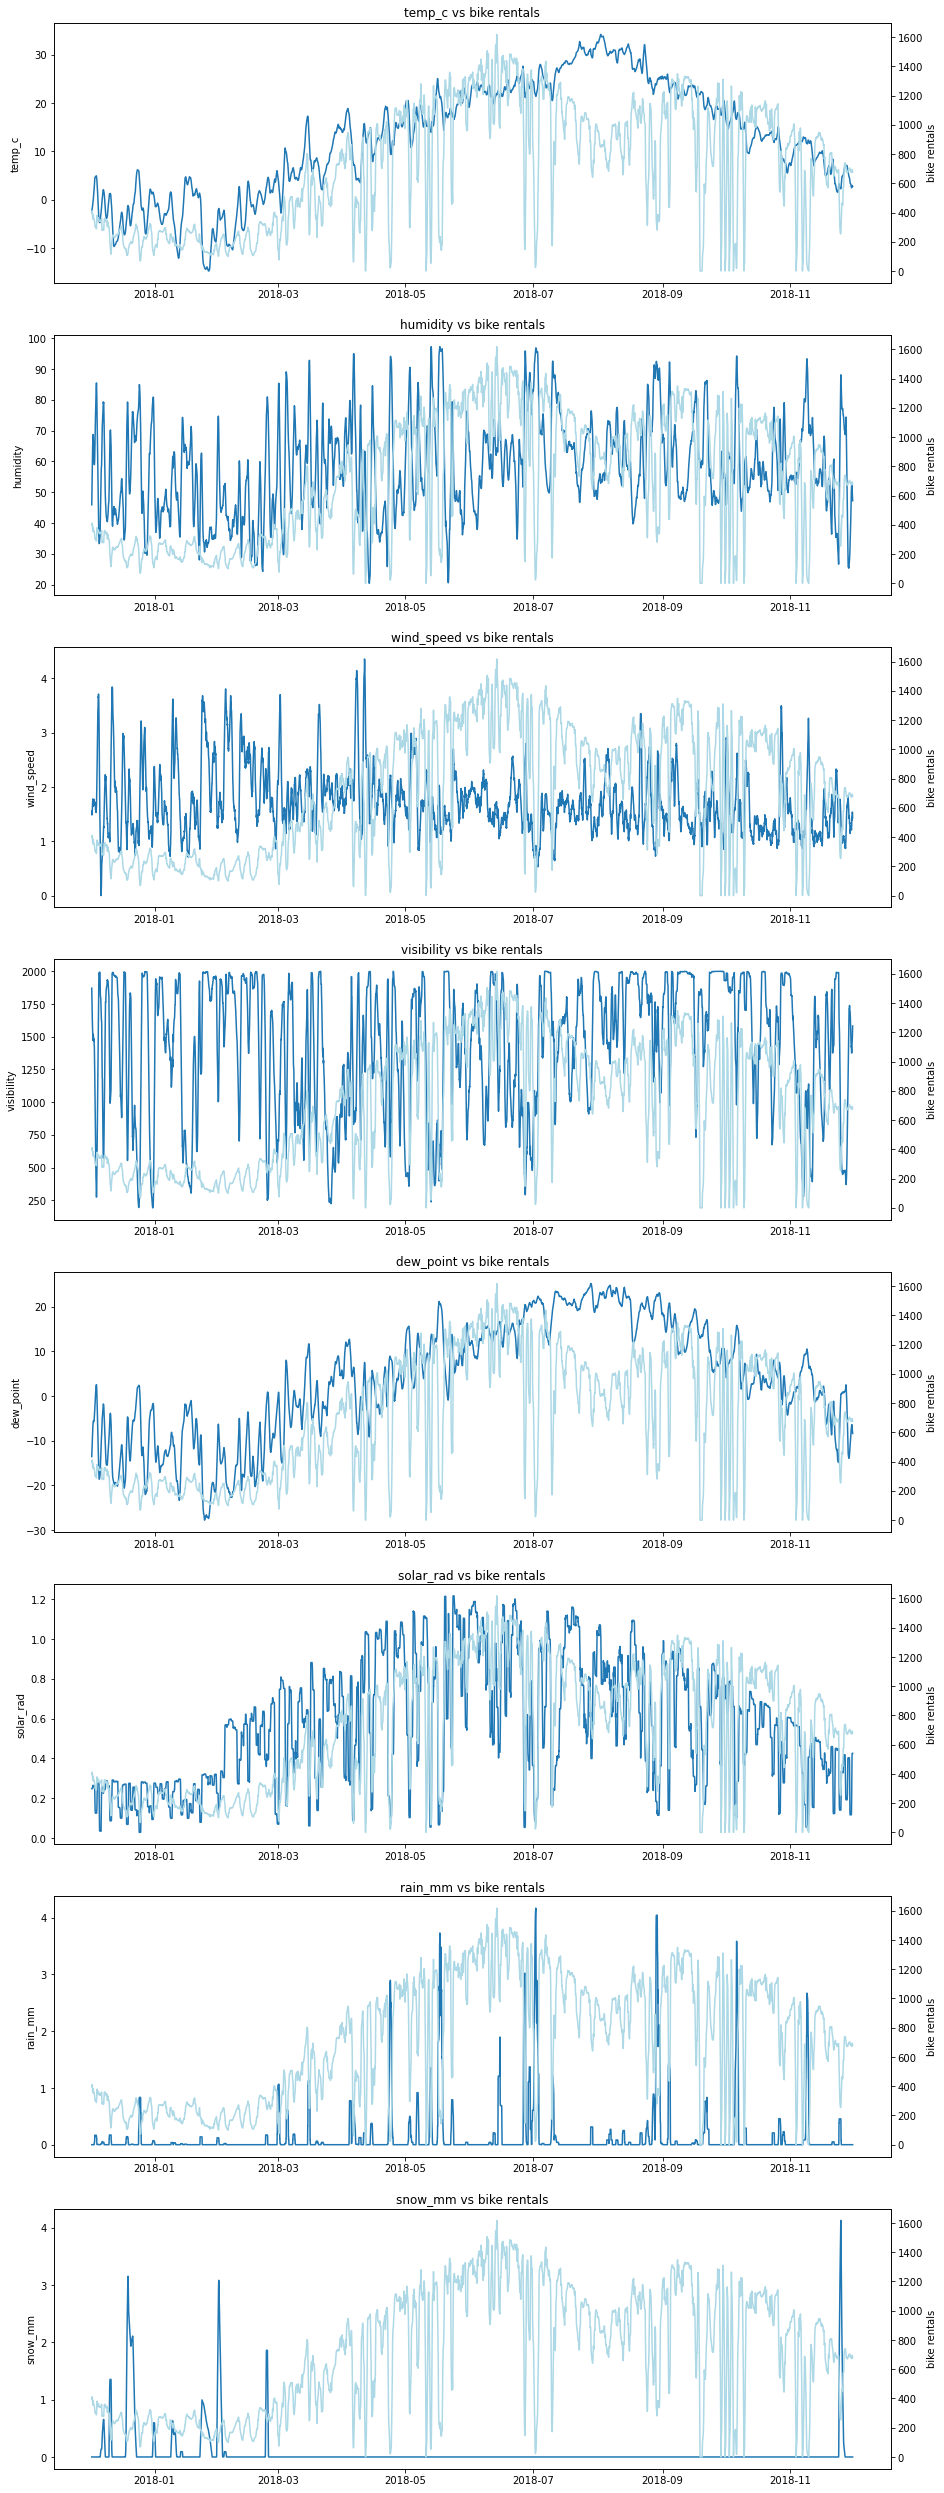

In [6]:
# remove variables not in plot and define plot space
bike_subplots = bike_share[bike_share.columns.difference(['hour', 'date_time', 'bike_count'], sort = False)]
subplot_varname = bike_subplots.columns
fig, ax = plt.subplots(8, 1, figsize=(15, 45))

ax = ax.ravel()

# iterative loop to plot twin axes plot. Used range(0, 8) to omit the last variables that are categorical
for i, var in zip(range(0, 8), subplot_varname):
    ax[i].set_title(str(var)+' vs bike rentals')
    ax[i].plot(bike_subplots[var].rolling(24).mean())
    ax[i].set_ylabel(var)
    ax2 = ax[i].twinx()
    ax2.plot(bike_share['bike_count'].rolling(24).mean(), 'lightblue')
    ax2.set_ylabel('bike rentals')

The plot above shows some interesting insight to the data. 
- Temperature shows expected trends such as seasonal trends with an overall peak during the summer. The number of bike rentals shrinks and rises with the temperature then at approximately 25 Cecius the number of bike rentals declines until the temperature falls back below 25.
- Humidity, wind speed show a lot of variation, however visibility has the highest variation.
- Dew point and solar radiation resembles the trends in bike rentals, with the exception when the dew point reaches its highest point. This is also the region where the temperature is at its peak. 
- The rain and snow variables show some scarcity which are expected trends. The bike rental count also seems to dip when there is rain or snow.

### Categorical Variables
Next the categorical variables will be visualized to see their distribution.

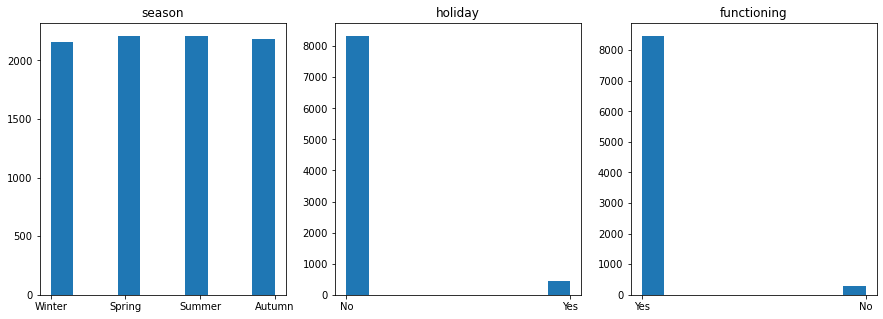

In [7]:
#create histograms for categorical variables: season, holiday, functioning
hist_vars = bike_share[['season', 'holiday', 'functioning']]
var_name = hist_vars.columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, var in zip(range(0, 3), var_name):
    ax[i].set_title(var)
    ax[i].hist(bike_share[var])

The categorical variables show that the seasons are properly spaced with approximately the same number of observations in each season and there are few holidays and even fewer non-functioning days.

## Explore temperature and bike rental count
The temperature vs. bike count was one of the most clear when looked at on the twin-axes plot. A scatter plot will further explore this comparison.

Text(0, 0.5, 'log bike rentals')

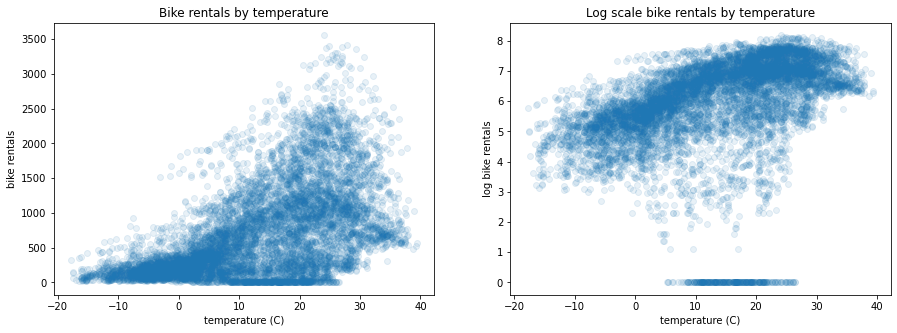

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot bike rental on normal scale
ax[0].scatter(bike_share['temp_c'], bike_share['bike_count'], alpha = 0.10)
ax[0].set_title('Bike rentals by temperature')
ax[0].set_xlabel('temperature (C)')
ax[0].set_ylabel('bike rentals')
# plot bike rental on log scale
ln_bike_count = np.log(bike_share['bike_count'] + 1)
ax[1].scatter(bike_share['temp_c'], ln_bike_count, alpha = 0.10)
ax[1].set_title('Log scale bike rentals by temperature')
ax[1].set_xlabel('temperature (C)')
ax[1].set_ylabel('log bike rentals')

On the left, the plot shows a scatter plot of number of bike rentals and the temperature. The low number of bike rentals are concentrated where the temperature is low. At higher temperatures the the number of bike rentals are more spread out, having a wider range. The higher temperatures will have a higher range because in the early morning hours of the summer it is most likely still warmer then the peak rental time of the winter.

On the right, the plot shows a scatter plot of the same variables but the number of bike rentals have been log transformed. The trend is more visible here, with the number of bike rentals rising with temperature until reaching around 25 Celcius then the number begins to fall. The days where there are no bike rentals are much more distinct here and are most likely from very early morning or non-functioning days. 

Although it seems that temperature does have an impact on bike rentals, the time of day is stll an important factor and will be explored next.

## plot hour vs bike rental count

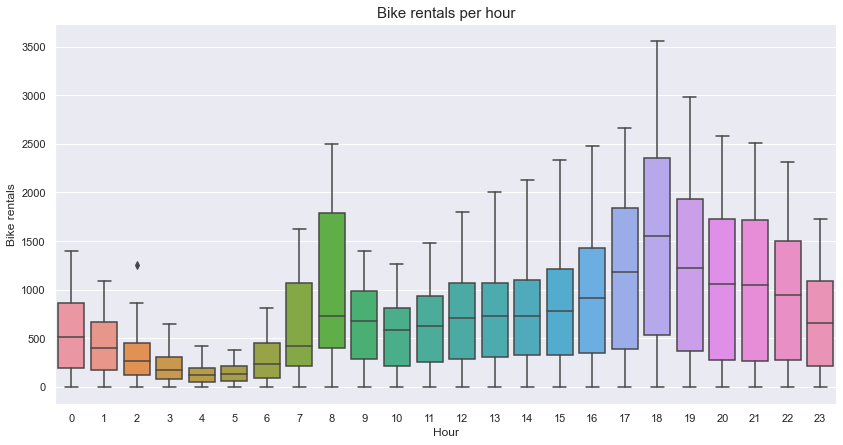

In [9]:
# create boxplots of bike rentals for each hour of the day
fontsize=15
sns.set_theme()
plt.figure(figsize=(14,7))
plt.title("Bike rentals per hour", fontdict={'fontsize': fontsize})
sns.boxplot(data=bike_share, x="hour", y="bike_count").set(xlabel="Hour", ylabel="Bike rentals")
plt.show()

The boxplot(above) shows how the bike rentals are distributed by the hour. The morning is most busy, on average, around 8am while the next peak is around 6pm.

## Prepare dataset for analysis

In [10]:
# encode seasons variable
bs_enc = pd.get_dummies(bike_share,
                                        prefix="season",
                                        columns=["season"],
                                        drop_first=True)
# change holiday and Functioning format to Yes=1 and No=0
bs_enc[['holiday_cat', 'function_cat']] = bs_enc[['holiday', 'functioning']].replace({'Yes':1, 'No':0})
# drop non-encoded columns
bs_enc.drop(['holiday', 'functioning'], axis=1, inplace=True)


## Linear Regression Pipeline
The first model will use standard scaler and lineatr regression in a pipeline. 

R^2 score: 0.5455151700928476 
RMSE:  433.3985460545897


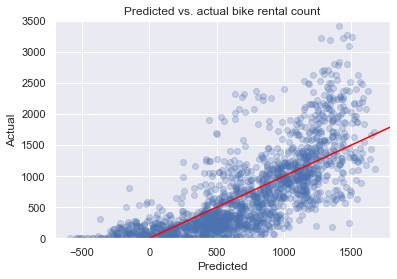

In [11]:
# import necessary modules for machine learning and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

# separate dataset into train and test set
X = bs_enc.drop(['bike_count', 'date_time'], axis = 1).values
y = bs_enc['bike_count'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# define and fit pipeline
scaler = StandardScaler()
linear = LinearRegression()

lr_pipe = Pipeline(steps=[('scaler', scaler), ('linear', linear)])
lr_pipe.fit(X_train, y_train)

# define function to caluclate metrics and plot for regression
def regression_scores_plot(X_test, y_test, model):
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    mse = MSE(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("R^2 score:", score, '\n'
          "RMSE: ", rmse)
    plt.scatter(y_pred, y_test, alpha=0.25)
    plt.ylim(0, 3500)
    plt.axline((1, 1), slope=1, c='red')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Predicted vs. actual bike rental count")
    plt.show()

regression_scores_plot(X_test, y_test, lr_pipe)

## Interpretation of results
According to the R^2 score of 0.55, 55% of the variation in the bike rentals in this model can be attributed to the independent variables. The RMSE score of 43 tells us that, on average, the model is able to predict the number of bike rentals within 433 bikes of the true number of bike rentals. There are many predicted values that are below zero which does not make sense because there cannot be a negative number of bikes rented. This model also does not accurately predict when there are a large number of bikes rented. 

## The next step
The first linear regression model left much room for improvement, thus Principle Component Ananysis (PCA) will be added to the model using GridsearchCV.

There is also more data management that can be done to improve the model. The bike_count and visibility variable will be log transformed because they both had a large variance and the trend on the predicted vs actual graph appears to follow an exponential trend so a log transformation may straighten the curve.

The rain_mm and snow_mm variables will be combined into a categorical variable that is 0 if there is no precipitation and 1 if there is precipitation. If there is a difference between bike rentals when it is raining/snowing, the model should be able to pick this up from the temperature variable. 

In [14]:
# duplicate rain variable to later convert to binary
bs_enc['rain_cat'] = bs_enc['rain_mm']

# convert to binary outcome
bs_enc.loc[bs_enc['rain_cat'] == 0, 'rain_cat'] = 0
bs_enc.loc[bs_enc['rain_cat'] > 0, 'rain_cat'] = 1

# do the same for the snow variable
bs_enc['snow_cat'] = bike_share['snow_mm']
bs_enc.loc[bs_enc['snow_cat'] == 0, 'snow_cat'] = 0
bs_enc.loc[bs_enc['snow_cat'] > 0, 'snow_cat'] = 1

# create precip_cat. 0 for no precipitaion and 1 for precipitation (rain and/or snow)
bs_enc['precip_cat'] = bs_enc['rain_cat'] + bs_enc['snow_cat']
bs_enc[bs_enc['precip_cat'] >= 1] = 1

# create log transformations
bs_enc['ln_vis'] = np.log(bs_enc['visibility'] + 1)
bs_enc['ln_bike_count'] = np.log(bs_enc['bike_count'] + 1)

# drop variables that arent needed
bs_enc.drop(['bike_count', 'visibility', 'date_time', 'rain_mm', 'rain_cat', 'snow_mm', 'snow_cat'], axis=1, inplace=True)

# create train and test set with new transformed variables
X = bs_enc.drop('ln_bike_count', axis = 1).values
y = bs_enc['ln_bike_count'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# define pipeline and parameters
pca = PCA(random_state=1)
scaler = StandardScaler()
linear = LinearRegression()

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('linear', linear)])

param_grid = {"pca__n_components": np.linspace(1, 13, 13, dtype=int)}

reg = GridSearchCV(pipe, param_grid, n_jobs=-1)

# create function to print best R^2 score and best parameters from a GridSearchCV or RandomizedSearchCV
def searchCV_scores(X_test, y_test, model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('best score:', score, '\n', 
      'best parameters:', model.best_params_)
    
searchCV_scores(X_test, y_test, reg)

best score: 0.9283584733257533 
 best parameters: {'pca__n_components': 13}


R^2 score:  0.9283584733257533 
 RMSE:  420.15080283464846


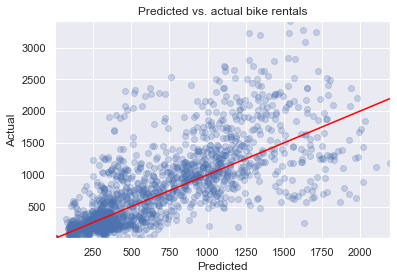

In [15]:
# run regression with the best parameters from gridsearch
pca = PCA(n_components=13, random_state=1)
scaler = StandardScaler()
linear = LinearRegression()
reg_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('linear', linear)])
reg_pipe.fit(X_train, y_train)

# define function to calculate R^2 score, RMSE and plot predicted v actual bike rental count
def model_score_plot(X_test, y_test, model):
    y_pred  = model.predict(X_test)
    score = model.score(X_test, y_test)
    # exponentiate y_pred and y_test because input is on log scale
    y_test_exp = np.exp(y_test)
    y_pred_exp = np.exp(y_pred)
    mse = MSE(y_test_exp, y_pred_exp)
    rmse = np.sqrt(mse)
    print('R^2 score: ', score, '\n',
        'RMSE: ', rmse)
    # predicted vs actual plot
    plt.scatter(x=y_pred_exp, y=y_test_exp, alpha=0.25)
    plt.xlim(y_pred_exp.min(), y_pred_exp.max())
    plt.ylim(y_test_exp.min(), y_test_exp.max())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Predicted vs. actual bike rentals")
    plt.axline((1, 1), slope=1, c='red')
    plt.show()

model_score_plot(X_test, y_test, reg_pipe)

The R^2 value (0.928) for this plot is better than the first linear regression model and the RMSE has also been lowered to 420. However being off by 420 bikes is certainly not ideal. This can be seen in the scatter plot that the predicted values are still not close to the red line.

# Random Forest Regressor
Random forest regressor will now be used in an attempt to increase the accuracy of the model and lower the RMSE. A pipeline will first be used with PCA and a basic random forest model to go through all the components in a gridsearch. This will be used as a 'ballpark' for n_components in hyperparameter-tuning, which allows the Random/Gridsearch to focus on searching through more parameters in the random forest regressor.

In [14]:
# define parameters for pipeline
pca = PCA(random_state=1)
scaler = StandardScaler()
rf = RandomForestRegressor(n_estimators=100, random_state=1)

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('rf', rf)])

param_grid = {
    "pca__n_components": np.linspace(1, 13, 13, dtype=int)
}

# run Gridsearch and calculate scores
rf_grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
searchCV_scores(X_test, y_test, rf_grid)

best score: 0.9639844731020536 
 best parameters: {'pca__n_components': 10}


In [15]:
# define parameters of pipeline
n_components = np.linspace(10, 13, 4, dtype=int)
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

pca = PCA(random_state=1)
scaler = StandardScaler()
rf = RandomForestRegressor(random_state=1, criterion='squared_error')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('rf', rf)])

random_grid= {'pca__n_components':  n_components,
              'rf__n_estimators': n_estimators,
              'rf__max_features': max_features,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
              }
# define and fit random search
rf_random = RandomizedSearchCV(estimator=pipe, param_distributions=random_grid, n_iter=100, cv=5, 
                              verbose=2, random_state=1, n_jobs=-1)
rf_random.fit(X_train, y_train)
# calculate best scores from random search
searchCV_scores(X_test, y_test, rf_random)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.9670691203018111 
 best parameters: {'rf__n_estimators': 1800, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 80, 'rf__bootstrap': False, 'pca__n_components': 10}


In [16]:
# define parameters of pipeline for gridsearch
n_components = [10]
n_estimators = [int(x) for x in np.linspace(start=1700, stop=2000, num=10)]
max_features = ['sqrt']
max_depth = [80]
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [False]

pca = PCA(random_state=1)
scaler = StandardScaler()
rf = RandomForestRegressor(random_state=1, criterion='squared_error')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('rf', rf)])

random_grid= {'pca__n_components':  n_components,
              'rf__n_estimators': n_estimators,
              'rf__max_features': max_features,
              'rf__max_depth': max_depth,
              'rf__min_samples_split': min_samples_split,
              'rf__min_samples_leaf': min_samples_leaf,
              'rf__bootstrap': bootstrap
              }

# define and fit gridsearch
rf_random = GridSearchCV(estimator=pipe, param_grid=random_grid, cv=5, 
                              verbose=2, n_jobs=-1)
rf_random.fit(X_train, y_train)
# calculate scores
searchCV_scores(X_test, y_test, rf_random)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best score: 0.9670610698702713 
 best parameters: {'pca__n_components': 10, 'rf__bootstrap': False, 'rf__max_depth': 80, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 1700}


R^2 score:  0.9670691203018111 
 RMSE:  271.68225004034934


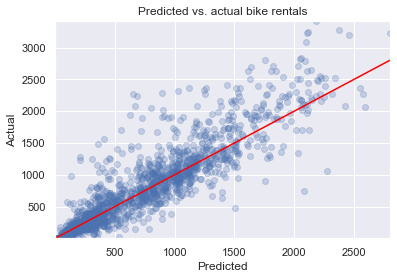

In [20]:
# define best parameters for pipeline
pca = PCA(n_components=10, random_state=1)
scaler = StandardScaler()
rf = RandomForestRegressor(n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                           max_depth=80, bootstrap=False, random_state=1)

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('rf', rf)])

# fit pipeline
rf_pipe = pipe.fit(X_train, y_train)

# calcuate scores
model_score_plot(X_test, y_test, rf_pipe)

The random forest model with hyper-parameter tuning was able to get an R^2 value of 0.967 and an RMSE of 272, which is the best so far. The data is a better fit than the linear regression model.

# Explainable Boosting

Explainable boosting will used to fit this data because it is a tree-based model, like random forest, but it also has automatic interaction detection and is able to visualize the importance of each variable.

In [16]:
# create a list of names of variables to be used in the EBR plot
names = ['hour', "temp_c", "humidity", "wind_speed", "dew_point", "solar_rad", "season_Spring", "season_Summer", 
         "season_Winter", "holiday_cat", "business_day_cat", "precip_cat", "ln_vis"]
ebr = ExplainableBoostingRegressor(random_state=1, feature_names=names)

ebr.fit(X_train, y_train)
print(ebr.score(X_test, y_test))

0.9693337552530518


The basic EBR model out-performed all the other models with an R^2 score of 0.969 and RMSE of 258. EBR will now be tuned to find the best hyperparameters.

Please note: hyperparameter tuning with explainable boosting is computationally expensive, the RandomizedSearchCV and GridsearchCV ran for over an hour each on my laptop.. 

In [19]:
# define parameters for random search
binning = ['quantile', 'quantile_humanized']
interactions = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_bins = [int(x) for x in np.linspace(start = 256, stop = 500, num=10)]
inner_bags = [int(x) for x in np.linspace(start=0, stop=10, num=5)]
outer_bags = [int(x) for x in np.linspace(start=8, stop=50, num=5)]

scaler = StandardScaler()
names = ["temp_c", "humidity", "wind_speed", "dew_point", "solar_rad", "season_Spring", "season_Summer", "season_Winter",
        "holiday_cat", "business_day_cat", "precip_cat", "ln_vis", "hour"]
ebr = ExplainableBoostingRegressor(random_state=1, feature_names=names)

# define and fit pipeline
pipe = Pipeline(steps=[('scaler', scaler), ('ebr', ebr)])

random_grid= {'ebr__binning': binning,
              'ebr__interactions': interactions,
              'ebr__max_bins': max_bins,
              'ebr__inner_bags': inner_bags,
              'ebr__outer_bags': outer_bags
              }


ebr_random = RandomizedSearchCV(estimator=pipe, param_distributions=random_grid, n_iter=10, cv=5, 
                              verbose=2, random_state=1, n_jobs=-1)
ebr_random.fit(X_train, y_train)

# print scores
searchCV_scores(X_test, y_test, ebr_random)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best score: 0.9736849386424978 
 best parameters: {'ebr__outer_bags': 39, 'ebr__max_bins': 310, 'ebr__interactions': 60, 'ebr__inner_bags': 0, 'ebr__binning': 'quantile_humanized'}


In [17]:
# define parameters for gridsearch
binning = ['quantile_humanized']
interactions = [int(x) for x in np.linspace(start=59, stop=61, num=3)]
max_bins = [310]
inner_bags = [0]
outer_bags = [int(x) for x in np.linspace(start=38, stop=40, num=3)]

scaler = StandardScaler()
names = ["temp_c", "humidity", "wind_speed", "dew_point", "solar_rad", "season_Spring", "season_Summer", "season_Winter",
        "holiday_cat", "business_day_cat", "precip_cat", "ln_vis", "hour"]
ebr = ExplainableBoostingRegressor(random_state=1, feature_names=names)

# define and fit pipeline
pipe = Pipeline(steps=[('scaler', scaler), ('ebr', ebr)])

random_grid= {'ebr__binning': binning,
              'ebr__interactions': interactions,
              'ebr__max_bins': max_bins,
              'ebr__inner_bags': inner_bags,
              'ebr__outer_bags': outer_bags
              }

ebr_grid = GridSearchCV(estimator=pipe, param_grid=random_grid, cv=5, 
                              verbose=2, n_jobs=-1)
ebr_grid.fit(X_train, y_train)

# print grisdearch scores
searchCV_scores(X_test, y_test, ebr_grid)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score: 0.9736824773180779 
 best parameters: {'ebr__binning': 'quantile_humanized', 'ebr__inner_bags': 0, 'ebr__interactions': 61, 'ebr__max_bins': 310, 'ebr__outer_bags': 40}


The best score from explainable boosting is 0.973 which is greater than the random forest model was able to achieve. Below is a comparison of each model.

In [18]:
# define parameters for EBR and create a list of names to be used for the explainable boosting plot
scaler = StandardScaler()
names = ["temp_c", "humidity", "wind_speed", "dew_point", "solar_rad", "season_Spring", "season_Summer", "season_Winter",
        "holiday_cat", "business_day_cat", "precip_cat", "ln_vis", "hour"]
ebr = ExplainableBoostingRegressor(random_state=1, feature_names=names, binning='quantile_humanized', inner_bags=0,
                                  interactions=61, max_bins=310, outer_bags=40)

ebr_pipe = Pipeline(steps=[('scaler', scaler), ('ebr', ebr)])

ebr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ebr',
                 ExplainableBoostingRegressor(binning='quantile_humanized',
                                              feature_names=['temp_c',
                                                             'humidity',
                                                             'wind_speed',
                                                             'dew_point',
                                                             'solar_rad',
                                                             'season_Spring',
                                                             'season_Summer',
                                                             'season_Winter',
                                                             'holiday_cat',
                                                             'business_day_cat',
                                                             'precip_cat',
                                                             'ln_vis', 'hour',
                                                             'temp_c x '
                                                             'precip_cat',
                                                             'humidity x '
                                                             'precip_cat',
                                                             'temp_c x '
                                                             'hum...
                                                             'continuous',
                                                             'continuous',
                                                             'continuous',
                                                             'continuous',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction',
                                                             'interaction', ...],
                                              interactions=61, max_bins=310,
                                              outer_bags=40, random_state=1))])

Linear Regression
R^2 score:  0.9283584733257533 
 RMSE:  420.15080283464846


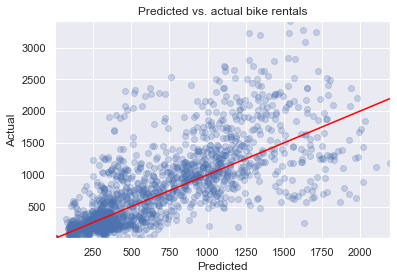

Random Forest
R^2 score:  0.9670691203018111 
 RMSE:  271.68225004034934


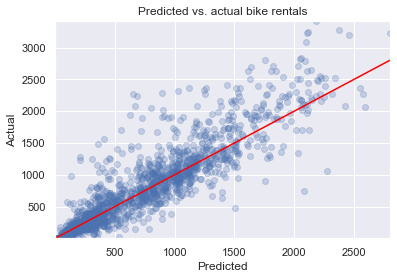

Explainable Boosting
R^2 score:  0.9736824773180779 
 RMSE:  241.5611917915113


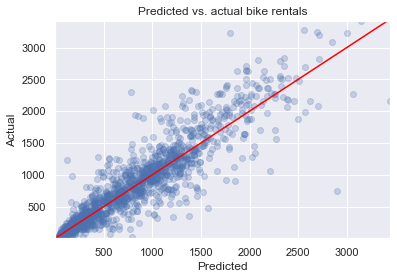

In [21]:
# print scores and plots ot linear regression, random forest, and explainable boosting for comparison
print('Linear Regression')
model_score_plot(X_test, y_test, reg_pipe)
print('Random Forest')
model_score_plot(X_test, y_test, rf_pipe)
print('Explainable Boosting')
model_score_plot(X_test, y_test, ebr_pipe)

- The overall best model is the explainable boosting regressor. It reached an R^2 score of 0.973 and an RMSE of 241. A drawback to this model is computation time. My focus was on finding a model with the lowest RMSE so I chose to do a gridsearch over many parameters which took a while to run on my laptop, therefore checking with the computational resources available is very important on when using this model.
- The random forest model had an R^2 value of 0.967 and an RMSE of 271.
- The Linear Regression scored the lowest of the three with an R^2 of 0.928 and an RMSE of 420.

## Explainable Boosting Variable Importance

This model not only has better scores but is also easily interpretable with the interpretML package that shows the importance of each variable. The output for this wil not appear on the github jupyter notebook, so I have included the results (as a .png file) in the git hub repository named 'Bike Share Explainable Boosting Rgressor Variable Importance Results'.

In [22]:
# import the following in order to remove UserWarning
from dash import html
from dash import dcc
from dash import dash_table as dt

In [23]:
# Explainable boosting chart to explain importance of variables
ebr_global = ebr.explain_global()
show(ebr_global)

C:\Users\david\anaconda3\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\david\anaconda3\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\david\anaconda3\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/2343984342112/ -->

## Conclusion
The explainable boosting regressor is a glassbox model that allows us to see which variables are important in the prediction. This is helpful because most machine learning algorithms are known as blackbox models that do not give insight to the variables. From the output above we see that the 4 most important factors are (1) precipitation, (2) humidity, (3) temperature, and (4) holiday. This gives important insight to the company because weather seems to have a great impact on bike rentals, and the company should show interest in what the weather conditions are in order to determine how many bikes are needed.